In [1]:
%load_ext autoreload
%autoreload 2

In [23]:
import numpy as np

# PLOTTING
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.5)
import matplotlib.gridspec
import collections
import os
import math

# PYTORCH 
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import transforms, utils
import torch.nn as nn
import torch.optim as optim



### Create dataset 

In [3]:
from dataset import MidiDataset

In [11]:
num_files_desired = 100000
midi_train_dataset = MidiDataset(num_files=num_files_desired, data_type="train")
midi_val_dataset   = MidiDataset(num_files=num_files_desired, data_type="val")
midi_test_dataset  = MidiDataset(num_files=num_files_desired, data_type="test")

File shape:  116189
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.
[Parallel(n_jobs=100)]: Done   1 tasks      | elapsed:    9.5s
[Parallel(n_jobs=100)]: Done   3 out of  60 | elapsed:    9.6s remaining:  3.0min
[Parallel(n_jobs=100)]: Done   5 out of  60 | elapsed:   10.0s remaining:  1.8min
[Parallel(n_jobs=100)]: Done   7 out of  60 | elapsed:   10.2s remaining:  1.3min
[Parallel(n_jobs=100)]: Done   9 out of  60 | elapsed:   10.4s remaining:   58.8s
[Parallel(n_jobs=100)]: Done  11 out of  60 | elapsed:   10.8s remaining:   47.9s
[Parallel(n_jobs=100)]: Done  13 out of  60 | elapsed:   10.8s remaining:   39.1s
[Parallel(n_jobs=100)]: Done  15 out of  60 | elapsed:   11.2s remaining:   33.7s
[Parallel(n_jobs=100)]: Done  17 out of  60 | elapsed:   11.6s remaining:   29.4s
[Parallel(n_jobs=100)]: Done  19 out of  60 | elapsed:   15.2s remaining:   32.8s
[Parallel(n_jobs=100)]: Done  21 out of  60 | elapsed:   15.3s remaining:   28.5s
[Parallel(n_jobs=1

In [27]:
trainloader = DataLoader(midi_train_dataset, batch_size=4,
                        shuffle=True, num_workers=4)
valloader   = DataLoader(midi_val_dataset, batch_size=4,
                        shuffle=True, num_workers=4)


In [28]:
test_batch_size = 256
testloader  = DataLoader(midi_test_dataset, batch_size=test_batch_size,
                        shuffle=False, num_workers=4)

### Create network

In [29]:
from models import Net
net = Net()
print(net)

N2,  46.0
Out pooling:  43.0
Net(
  (conv1): Conv1d(384, 64, kernel_size=(5,), stride=(1,))
  (conv2): Conv1d(64, 16, kernel_size=(4,), stride=(1,))
  (fc1): Linear(in_features=688, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=250, bias=True)
  (fc3): Linear(in_features=250, out_features=128, bias=True)
)


In [30]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### Train the network

In [31]:
net = net.double()

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
#         print("Inputs: ", inputs.shape)
#         print("Labels: ", labels.shape)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs.double())
        loss = criterion(outputs, labels.double())
        loss.backward()
        optimizer.step()

        # print statistics
        if i % 100 == 0:   
            print("Epoch: ", epoch, ", Iter, ", i, ", Loss: ", loss.item())

print('Finished Training')

Epoch:  0 , Iter,  0 , Loss:  0.6942638950557938
Epoch:  0 , Iter,  100 , Loss:  0.6919180833360761
Epoch:  1 , Iter,  0 , Loss:  0.6908781191048111
Epoch:  1 , Iter,  100 , Loss:  0.6885210046882646
Finished Training


### Save the network

In [33]:
PATH = './midi_net.pth'
torch.save(net.state_dict(), PATH)

### Test the network

In [35]:
PLAYING_THRESH = 0.05

num_notes = 128

test_labels = np.zeros((len(testloader.dataset), num_notes))
test_preds  = np.zeros((len(testloader.dataset), num_notes))

sigmoid = torch.nn.Sigmoid()

with torch.no_grad():
    idx = 0
    for data in testloader:
        inputs, labels = data
    
        
        test_labels[idx:idx+labels.shape[0], :] = labels.cpu().numpy()

        outputs = net(inputs)
        outputs = sigmoid(outputs)
        test_preds[idx:idx+labels.shape[0], :] = outputs.cpu().numpy()
        
        idx = idx + labels.shape[0]
 
import copy
test_preds_probs = copy.deepcopy(test_preds)

test_preds[test_preds <  PLAYING_THRESH] = 0
test_preds[test_preds >= PLAYING_THRESH] = 1

In [36]:
def evaluate_metrics(preds, labels): 
    correct = 0.0
    total = 0.0
    num_true_pos_label  = 0.0
    num_false_pos_label = 0.0
    num_pos_pred  = 0.0
    num_true_neg_label  = 0.0
    num_false_neg_label = 0.0
    num_neg_pred  = 0.0

    num_timesteps = labels.shape[0]

    for i in range(num_timesteps): 
        for j in range(num_notes):
            if (labels[i,j] == 1.0):
                num_pos_pred += 1.0
            else: 
                num_neg_pred += 1.0

            if (preds[i,j] == labels[i,j]): 
                if (preds[i,j] == 1.0):
                    num_true_pos_label += 1.0
                else: 
                    num_true_neg_label += 1.0
                correct += 1.0
            else: 
                if (preds[i,j] == 1.0): 
                    num_false_pos_label += 1.0
                else: 
                    num_false_neg_label += 1.0
            total += 1.0
            
    accuracy = correct/total 
    recall = num_true_pos_label / num_pos_pred
    
    return accuracy, recall 

### Get network metrics

In [37]:
accuracy, recall = evaluate_metrics(test_preds, test_labels)

ZeroDivisionError: float division by zero

In [38]:
print(accuracy)
print(recall)

NameError: name 'accuracy' is not defined

### PLOTS

In [39]:
def plot_data(x, y): 
    fig = plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.scatter(x, y, marker='_')
    plt.xlabel('Time (x0.01 s)')
    plt.ylabel('MIDI Pitch')
#     plt.ylim(top=384)
    plt.show()

(0, 2)
(0, 2)


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f84160825f0>
Traceback (most recent call last):
  File "/home/marion_lepert/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 926, in __del__
    self._shutdown_workers()
  File "/home/marion_lepert/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 906, in _shutdown_workers
    w.join()
  File "/home/marion_lepert/anaconda3/lib/python3.7/multiprocessing/process.py", line 140, in join
    res = self._popen.wait(timeout)
  File "/home/marion_lepert/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 48, in wait
    return self.poll(os.WNOHANG if timeout == 0.0 else 0)
  File "/home/marion_lepert/anaconda3/lib/python3.7/multiprocessing/popen_fork.py", line 28, in poll
    pid, sts = os.waitpid(self.pid, flag)
KeyboardInterrupt: 


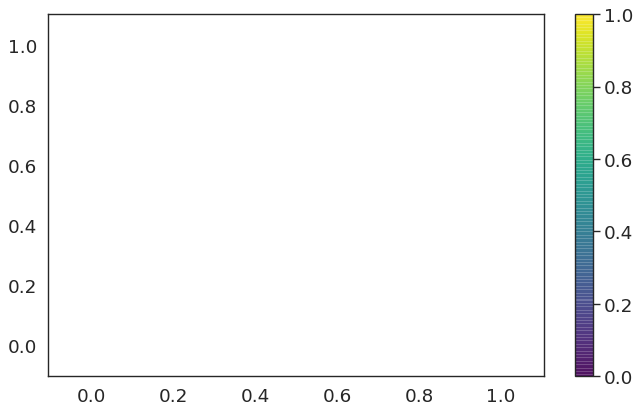

In [40]:
test_preds_plt = np.argwhere(test_preds > 0)
test_preds_plt_indices = np.where(test_preds > 0)
test_preds_colors = test_preds_probs[test_preds_plt_indices]

test_labels_plt = np.argwhere(test_labels > 0)


# print(test_preds_colors)
# plot_data(test_preds_plt[:,0], test_preds_plt[:,1])

print(test_labels_plt.shape)
print(test_preds_plt.shape)

fig = plt.figure(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(test_preds_plt[:,0], test_preds_plt[:,1], c=test_preds_colors, cmap="viridis", alpha=0.75,  s=4)
plt.colorbar()
plt.scatter(test_labels_plt[:,0], test_labels_plt[:,1], c='r', s=1)


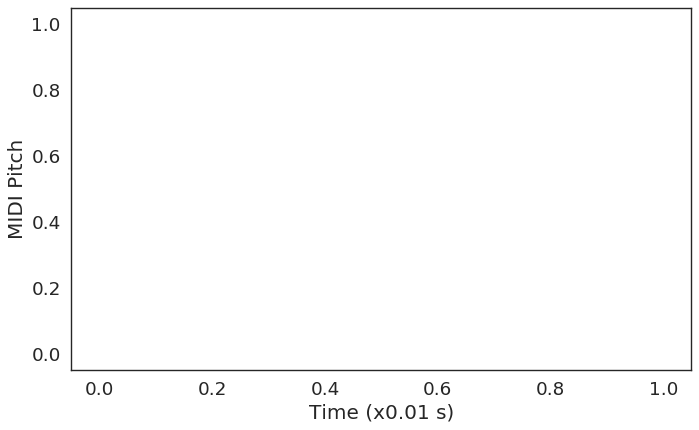

In [41]:
test_labels_plt = np.argwhere(test_labels > 0)
plot_data(test_labels_plt[:,0], test_labels_plt[:,1])

In [42]:
plt.imshow(outputs_np)

NameError: name 'outputs_np' is not defined

In [ ]:
plt.imshow(labels)